In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
import pandas as pd
import psutil
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model
import scipy as sp
import scipy.ndimage

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import cv2

import statsmodels.api as sm

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 20})

In [3]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_2/func_0'

In [4]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 92.35 ms


# Load PCs

In [5]:
t0 = time()
save_file = os.path.join(directory, 'pca', 'scores_(spatial).npy')
pca_spatial = np.load(save_file)
save_file = os.path.join(directory, 'pca', 'loadings_(temporal).npy')
pca_loadings = np.load(save_file)
print('Duration: {}'.format(time()-t0))

Duration: 21.59421730041504


### Alternatively, Perform PCA

In [ ]:
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
brain = bbb.load_numpy_brain(brain_path)
dims = bbb.get_dims(brain)
print('brain shape is x,y,z,t {}'.format(brain.shape))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 12.90 sec
brain shape is x,y,z,t (88, 128, 55, 4006)


In [ ]:
t0 = time()
X = brain[:,:,:,:].reshape(-1,brain.shape[-1]).T
print('X is time by voxels {}'.format(X.shape))
print('Reshape duration: {}'.format(time()-t0))

t0 = time()
pca = PCA().fit(X)
pca_scores = pca.components_
print('Scores is PC by voxel {}'.format(pca_scores.shape))
pca_loadings = pca.transform(X)
print('Loadings is time by PC {}'.format(pca_loadings.shape))
pca_spatial = np.reshape(pca_scores, (-1,dims['x'],dims['y'],dims['z']))
print('Spatial is {}'.format(pca_spatial.shape))
print('PCA duration: {}'.format(time()-t0))

In [ ]:
save_file = os.path.join(directory, 'pca', 'scores_(spatial).npy')
np.save(save_file, pca_spatial)
save_file = os.path.join(directory, 'pca', 'loadings_(temporal).npy')
np.save(save_file, pca_loadings)

# Load and Process Fictrac

In [6]:
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_fictrac ~~
load_fictrac done. Duration: 3.43 sec


In [7]:
def interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, interp_to):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    sphere_radius = 4.5e-3
    filter_window = 11
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'all':
        dx = np.asarray(fictrac['dRotLabX'])
        dy = np.asarray(fictrac['dRotLabY'])
        dz = np.asarray(fictrac['dRotLabZ'])
        dx = scipy.signal.savgol_filter(dx,filter_window,3) * sphere_radius * 50 * 100 * 10
        dy = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
        dz = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
        fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    elif behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
    else:
        print('invalid behavior')
    
    #fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    
    if interp_to is 'timestamps':
        fictrac_interp = fictrac_interp_temp(timestamps[:,25])
    elif interp_to is 'xnew':
        fictrac_interp = fictrac_interp_temp(xnew)
    else:
        print('Invalid interp_to ({})'.format(interp_to))

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [8]:
resolution = 50 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
xnew = np.arange(0,expt_len,resolution)

fictracs_high_res = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs_high_res[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'xnew')

fictracs = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'timestamps')

Text(0.5, 1.0, 'Brain interp space zoom')

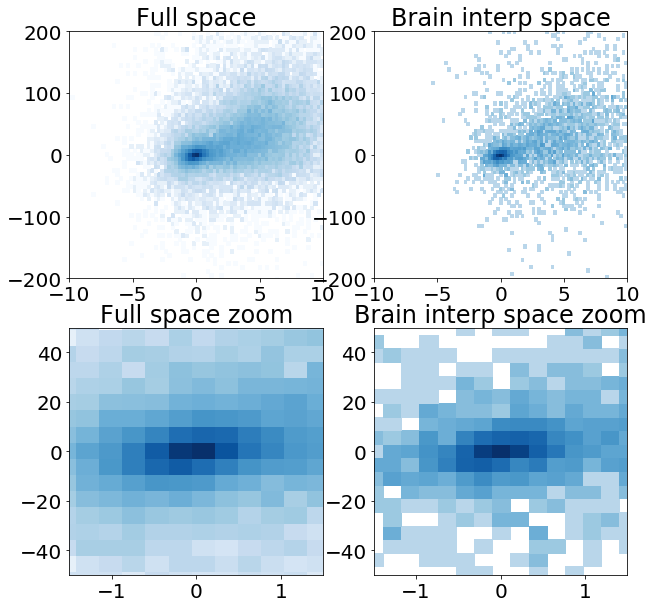

In [9]:
plt.figure(figsize=(10,10))
#norm = None
norm = mpl.colors.LogNorm()
#norm = mpl.colors.PowerNorm(.2)

plt.subplot(221)
plt.hist2d(fictracs_high_res['Y'],fictracs_high_res['Z'],bins=100,cmap='Blues',norm=norm);
plt.ylim(-200,200)
plt.xlim(-10,10)
plt.title('Full space')

plt.subplot(222)
plt.hist2d(np.repeat(fictracs['Y'],10),
           np.repeat(fictracs['Z'],10),
           bins=100,cmap='Blues',norm=norm);
plt.ylim(-200,200)
plt.xlim(-10,10)
plt.title('Brain interp space')

plt.subplot(223)
plt.hist2d(fictracs_high_res['Y'],fictracs_high_res['Z'],bins=100,cmap='Blues',norm=norm);
plt.ylim(-50,50)
plt.xlim(-1.5,1.5)
plt.title('Full space zoom')

plt.subplot(224)
h = plt.hist2d(np.repeat(fictracs['Y'],10),
           np.repeat(fictracs['Z'],10),
           bins=100,cmap='Blues',norm=norm);
plt.ylim(-50,50)
plt.xlim(-1.5,1.5)
plt.title('Brain interp space zoom')

# Bin PCs into behavior bins

In [ ]:
# For each bin in the histogram, it has collected several points from across time.
# Find those frame numbers.
# Then, get average value of PC across those timepoints!

In [10]:
def bin_pc(pc, num_bins_x, num_bins_y, idx_x ,idx_y):
    pc_binned = []
    pc_std = []
    pc_count = []
    pc_var = []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            pc_binned.append(np.mean(pc[mask]))
            pc_std.append(np.std(pc[mask]))
            pc_count.append(np.count_nonzero(~np.isnan(pc[mask])))
            pc_var.append(np.var(pc[mask]))
    pc_binned = np.flip(np.reshape(pc_binned,(num_bins_x, num_bins_y)).T,0)
    pc_std = np.flip(np.reshape(pc_std,(num_bins_x, num_bins_y)).T,0)
    pc_count = np.flip(np.reshape(pc_count,(num_bins_x, num_bins_y)).T,0)
    pc_var = np.flip(np.reshape(pc_var,(num_bins_x, num_bins_y)).T,0)
    pcs_binned = {'pc_binned': pc_binned,
                  'pc_std': pc_std,
                  'pc_count':pc_count,
                  'pc_var':pc_var}
    return pcs_binned

In [11]:
def smooth_with_nans(U):
    mode = 'reflect'
    truncate = 1
    sigma = 5

    V=U.copy()
    V[np.isnan(U)]=0
    VV=sp.ndimage.gaussian_filter(V,sigma=sigma,mode=mode,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=sp.ndimage.gaussian_filter(W,sigma=sigma,mode=mode,truncate=truncate)

    Z=VV/WW
    return Z

#### Create behavior bins and get indicies

In [12]:
num_bins_x, num_bins_y = 30, 30
start_x, end_x = -10, 25
start_y, end_y = -350, 350

#start_x, end_x = -10, 15
#start_y, end_y = -130, 130

# Define bins
bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)

# Assign fictrac values to bin numbers
idx_x, idx_y = np.digitize(fictracs['Y'],bins_x), np.digitize(fictracs['Z'],bins_y)

#### Bin PCs

In [13]:
pcs_binned = []
for i in range(30):
    pcs_binned.append(bin_pc(pca_loadings[:,i], num_bins_x, num_bins_y, idx_x ,idx_y))

#### Plot

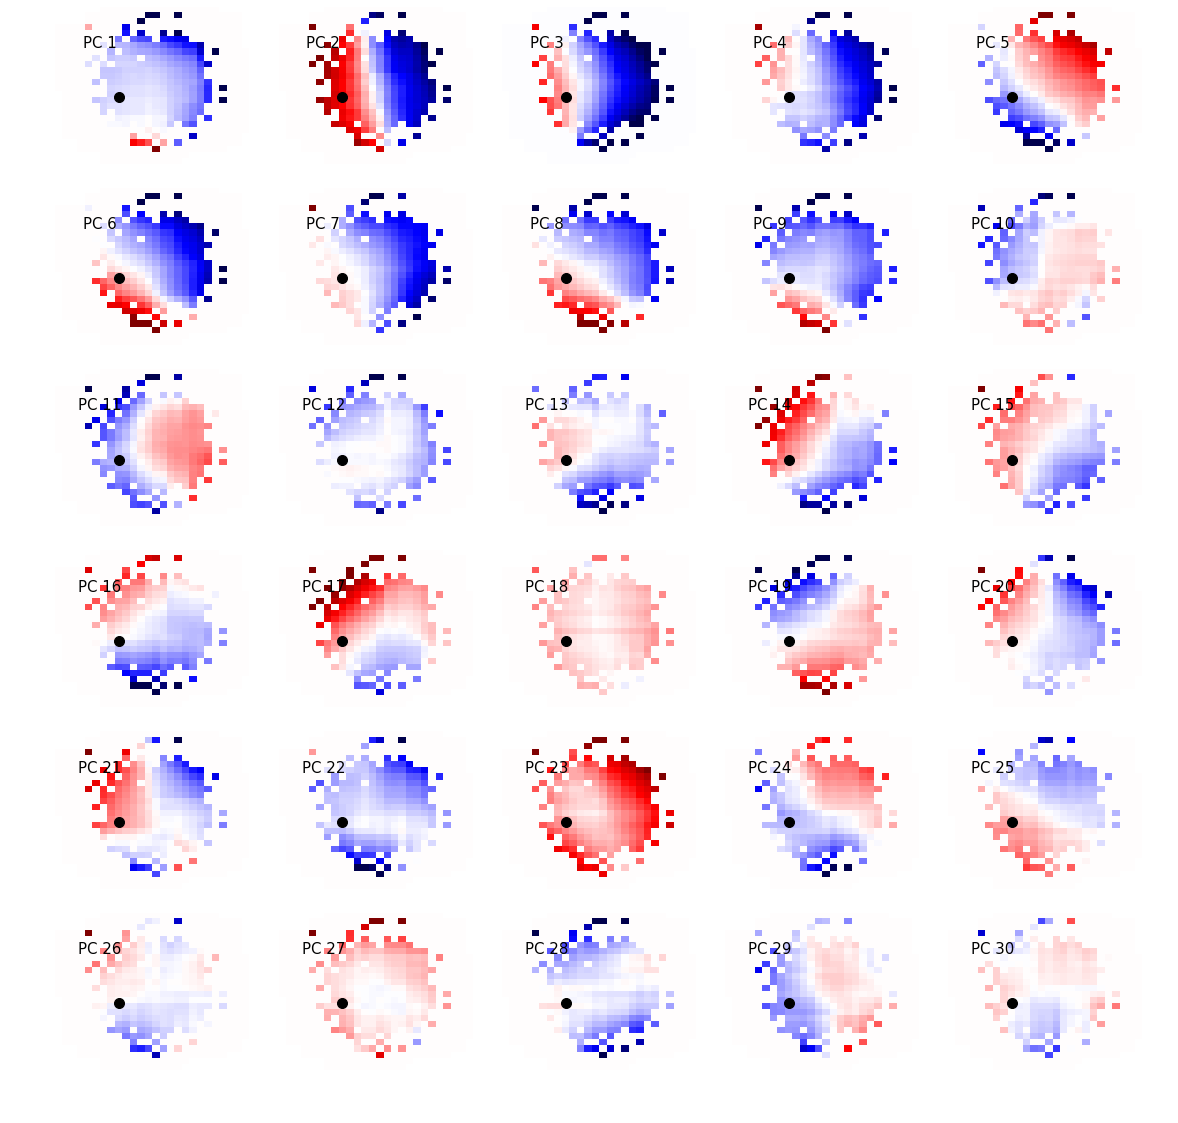

In [14]:
plt.figure(figsize=(20,20))
#norm = mpl.colors.LogNorm()
norm = None
contrast = 2
plt.rcParams.update({'font.size': 15})
pc_behavior_plots = []

for i in range(30):
    ax = plt.subplot(6,5,i+1)
    
    pc_bin_smooth = smooth_with_nans(pcs_binned[i]['pc_binned'])
    pc_std_smooth = smooth_with_nans(pcs_binned[i]['pc_std'])
    
    mask = ~np.isnan(pcs_binned[i]['pc_binned'])
    z_score = np.divide(pc_bin_smooth,pc_std_smooth)
    z_score_masked = np.multiply(z_score, mask)
    
    interp_mode = None
    ax.imshow(z_score_masked,
              cmap='seismic',
              aspect='auto',
              extent=(start_x,end_x,start_y,end_y),
              interpolation=interp_mode,
              norm=norm,
              vmin=-1,
              vmax=1)

    plt.scatter(0,0,100,color='k')
    ax.axis('off')
    ax.text(.2, .8,
             'PC {}'.format(i+1),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax.transAxes)
    pc_behavior_plots.append(z_score_masked)

plt.subplots_adjust(wspace=0, hspace=0)

# Can we cluster the PC behavior maps?

In [31]:
from sklearn.cluster import KMeans

In [22]:
pc_behavior = np.asarray(pc_behavior_plots)
# shape will be num_plots,x,y
pc_behavior.shape = (pc_behavior.shape[0], -1)

In [41]:
pc_behavior.shape

(30, 900)

In [35]:
np.nan_to_num(pc_behavior, copy=False);

In [76]:
n_clusters = 7
kmeans = KMeans(n_clusters).fit(pc_behavior)

In [77]:
clusters = [[] for i in range(n_clusters)]
for i in range(len(kmeans.labels_)):
    clusters[kmeans.labels_[i]].append(pc_behavior[i,:])

Text(0.5, 0.98, 'first clustering attempt')

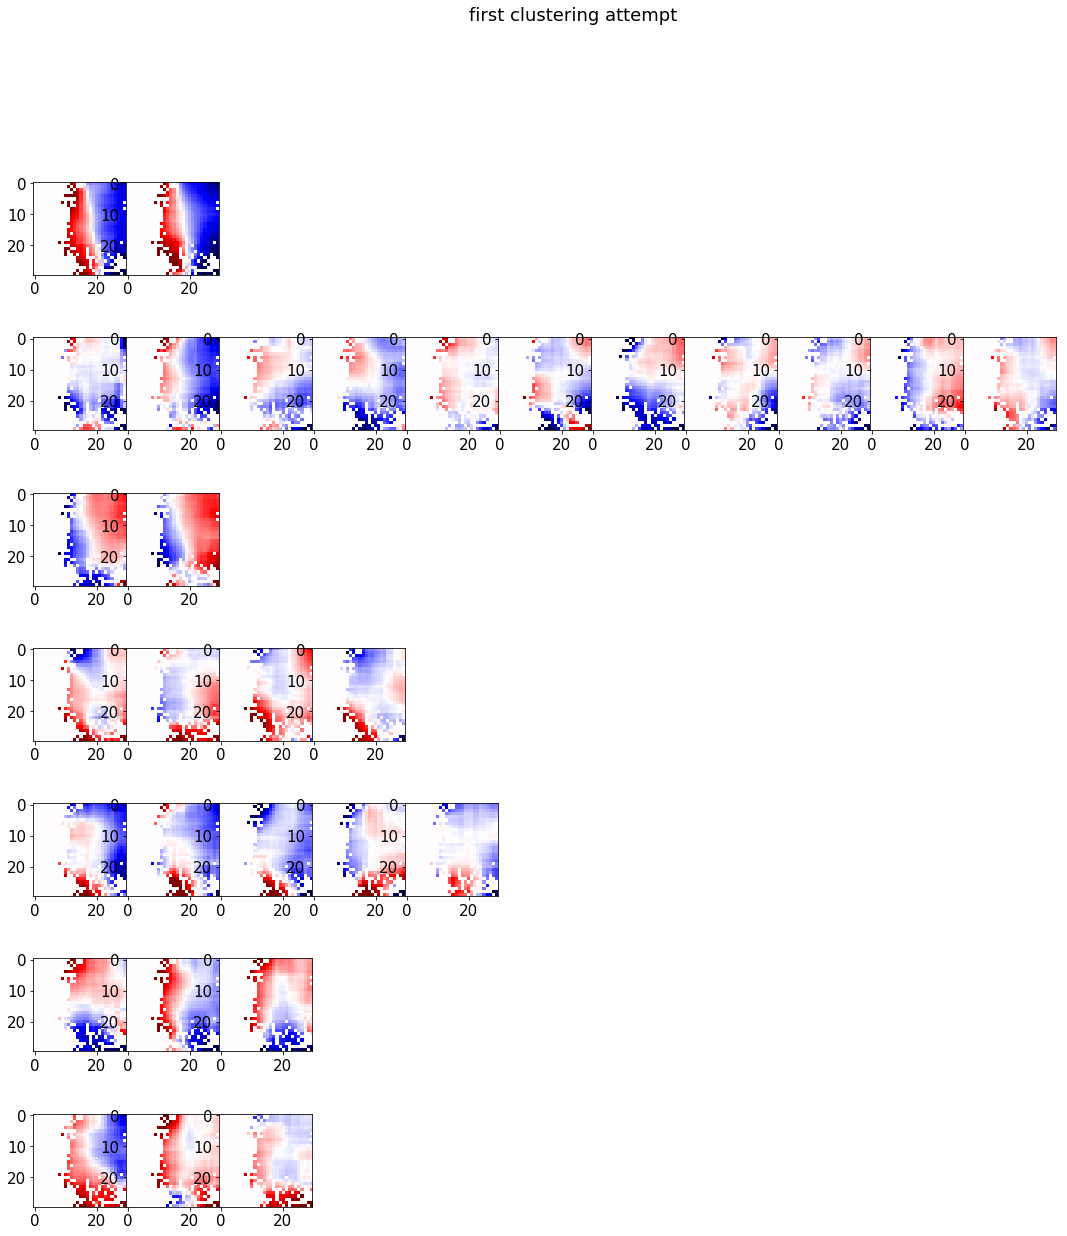

In [107]:
plt.figure(figsize=(20,20))
for i in range(n_clusters):
    for j in range(np.shape(clusters[i])[0]):
        ax = plt.subplot(n_clusters,12,(i*12)+j+1)
        #mask = ~np.isnan(pcs_binned[i]['pc_binned'])
        #z_score = np.divide(pc_bin_smooth,pc_std_smooth)
        #z_score_masked = np.multiply(z_score, mask)
        ax.imshow(np.reshape(clusters[i][j],(30,30)),
                   cmap='seismic',
                   vmin=-1, vmax=1)
        #ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('first clustering attempt')

In [ ]:
def cluster_brain(voxels, voxels_where, r2, n_clusters):
    kmeans = KMeans(n_clusters).fit(voxels)

    clusters = [[] for i in range(n_clusters)]
    for i in range(len(kmeans.labels_)):
        clusters[kmeans.labels_[i]].append(voxels[i,:])

    clustered_brain = np.zeros(r2.shape)
    for i in range(voxels_where.shape[-1]): 
        clustered_brain[voxels_where[0,i], voxels_where[1,i], voxels_where[2,i]] = kmeans.labels_[i]+1
    return clustered_brain

# What about fft?

In [44]:
def fft_signal(signal, sampling_rate, duration):
    """ Performs FFT on a signal.

    Parameters
    ----------
    signal: 1D numpy array
    sampling_rate: in Hz (I think... check)
    duration: int (in sec?). Can probably calulate this instead of requiring.

    Returns
    -------
    y: signal
    Y: fft
    t: times """
    
    Fs = sampling_rate
    y = signal
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,duration,Ts) # time vector
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range
    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(int(n/2))]
    return y,Y,t,frq

In [45]:
Ys = []
for i in range(30):
    y,Y,t,frq = fft_signal(pca_loadings[:,i],2.53833,1800)
    Ys.append(Y)

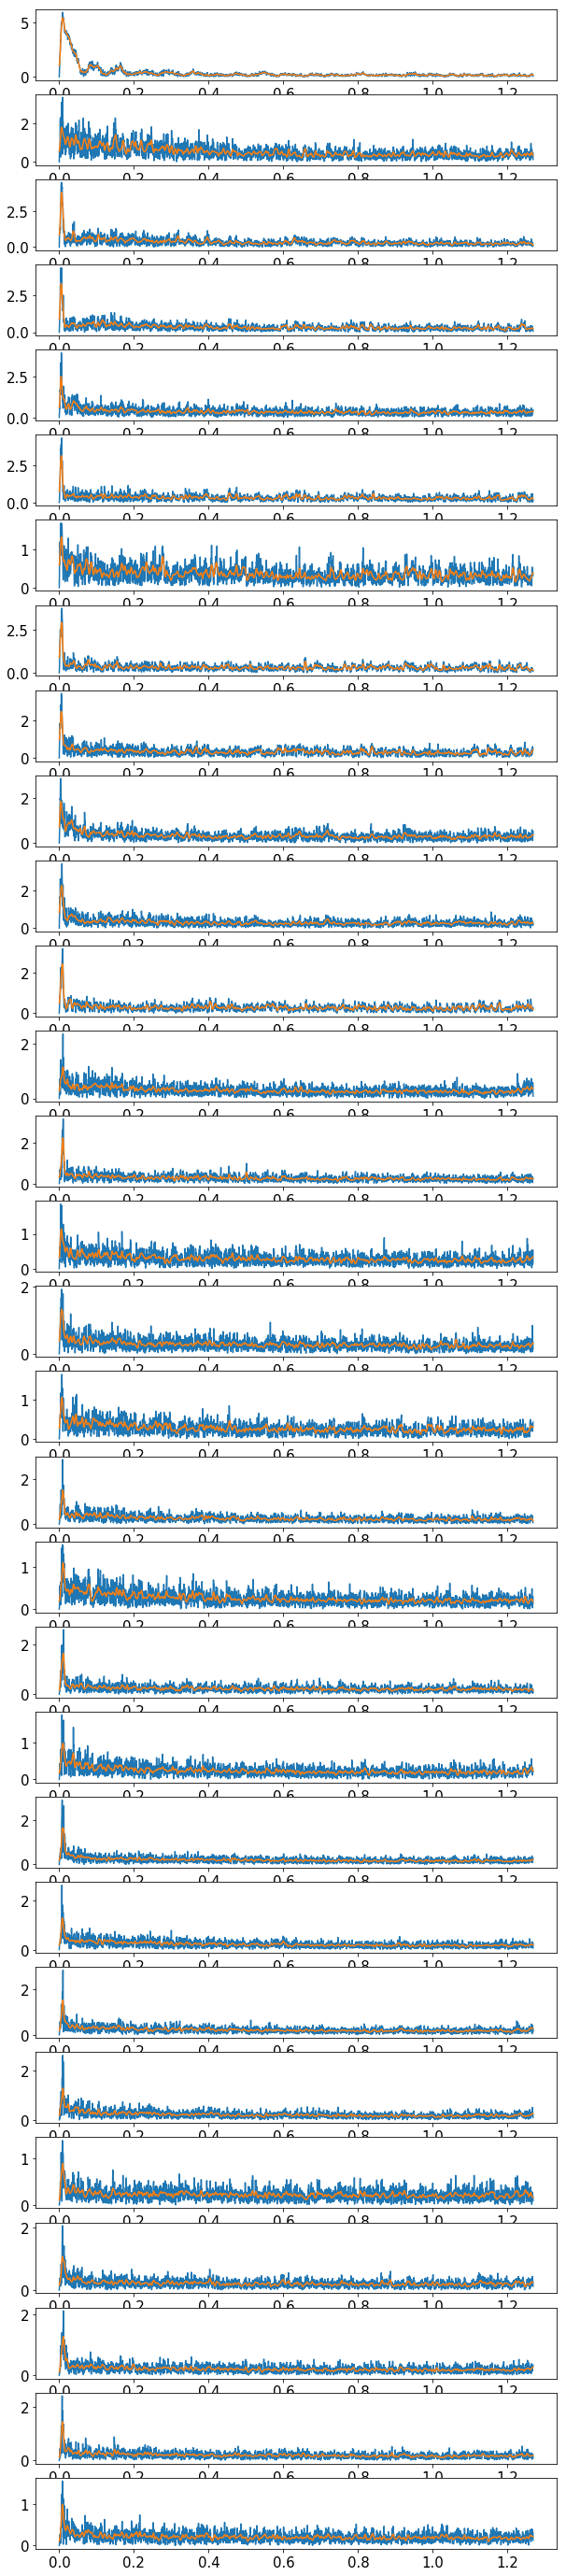

In [51]:
plt.figure(figsize=(10,50))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(frq,abs(Ys[i]))
    plt.plot(frq,sp.ndimage.gaussian_filter(abs(Ys[i]),3))

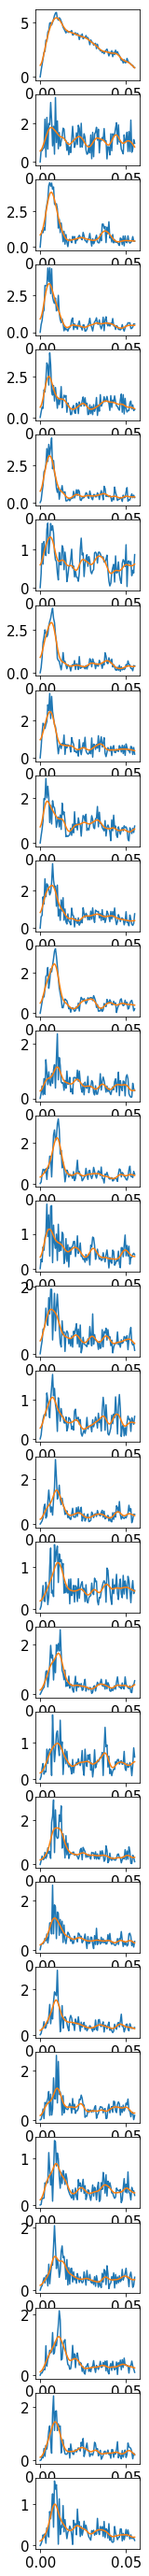

In [52]:
plt.figure(figsize=(2,50))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(frq[:100],abs(Ys[i][:100]))
    plt.plot(frq[:100],sp.ndimage.gaussian_filter(abs(Ys[i]),3)[:100])

Text(0.5, 0.92, 'PC 2')

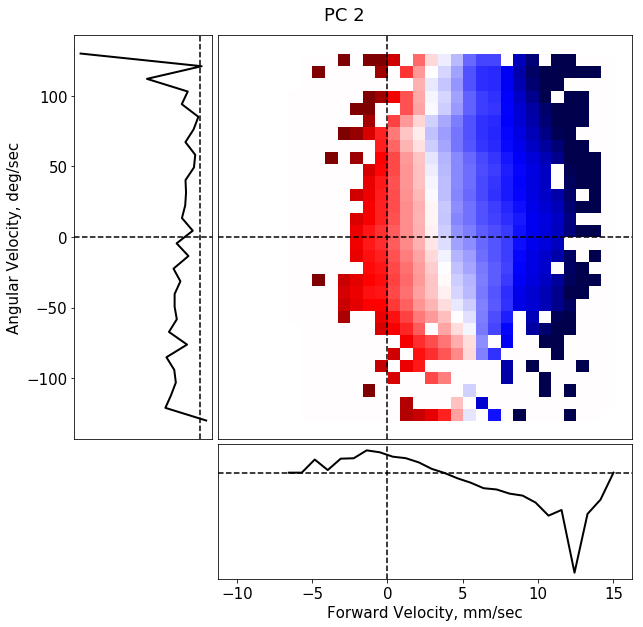

In [141]:
plt.figure(figsize=(10,10))
to_plot = pc_behavior_plots[1]

gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
ax_main = plt.subplot(gs[0,1])
ax_y = plt.subplot(gs[0,0], sharey=ax_main)
ax_x = plt.subplot(gs[1,1], sharex=ax_main)

ax_main.imshow(to_plot,
               cmap = 'seismic',
               aspect = 'auto',
               extent = (start_x,end_x,start_y,end_y),
               vmin=-1,vmax=1)

ax_y.plot(np.nanmean(to_plot,axis=1), bins_y, color='k', linewidth=2)
ax_x.plot(bins_x, np.nanmean(to_plot,axis=0), color='k', linewidth=2)

ax_main.axhline(0,linestyle='--',color='k')
ax_main.axvline(0,linestyle='--',color='k')
ax_x.axhline(0,linestyle='--',color='k')
ax_x.axvline(0,linestyle='--',color='k')
ax_y.axhline(0,linestyle='--',color='k')
ax_y.axvline(0,linestyle='--',color='k')

ax_y.xaxis.set_visible(False)
ax_x.yaxis.set_visible(False)
ax_main.xaxis.set_visible(False)
ax_main.yaxis.set_visible(False)
gs.update(wspace=0.02, hspace=0.02)
ax_y.set_ylabel('Angular Velocity, deg/sec')
ax_x.set_xlabel('Forward Velocity, mm/sec')
plt.suptitle('PC 2',y=.92)

Text(0.5, 0, 'Forward Velocity, mm/sec')

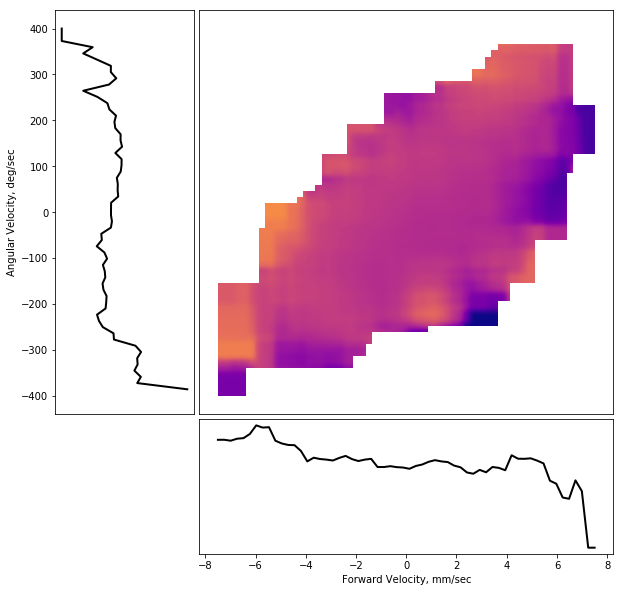

In [117]:
plt.figure(figsize=(10,10))
to_plot = pcs_binned[1]['pc_binned']

gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
ax_main = plt.subplot(gs[0,1])
ax_y = plt.subplot(gs[0,0], sharey=ax_main)
ax_x = plt.subplot(gs[1,1], sharex=ax_main)

ax_main.imshow(to_plot,cmap='plasma', aspect='auto', extent = (start_x,end_x,start_y,end_y),interpolation='gaussian')
ax_y.plot(np.nanmean(to_plot,axis=1), bins_y, color='k', linewidth=2)
ax_x.plot(bins_x, np.nanmean(to_plot,axis=0), color='k', linewidth=2)

ax_y.xaxis.set_visible(False)
ax_x.yaxis.set_visible(False)
ax_main.xaxis.set_visible(False)
ax_main.yaxis.set_visible(False)
gs.update(wspace=0.02, hspace=0.02)
ax_y.set_ylabel('Angular Velocity, deg/sec')
ax_x.set_xlabel('Forward Velocity, mm/sec')